# Transfer Learning with MobileNetV2

**Objectives:**
- Create a dataset from a directory
- Preprocess and augment data using the Sequential API
- Adapt a pretrained model to new data and train a classifier using the Functional API and MobileNet
- Fine-tune a classifier's final layers to improve accuracy

In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation


### 1.1 Create the Dataset and Split it into Training and Validation Sets

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 177 files belonging to 2 classes.
Using 142 files for training.
Found 177 files belonging to 2 classes.
Using 35 files for validation.


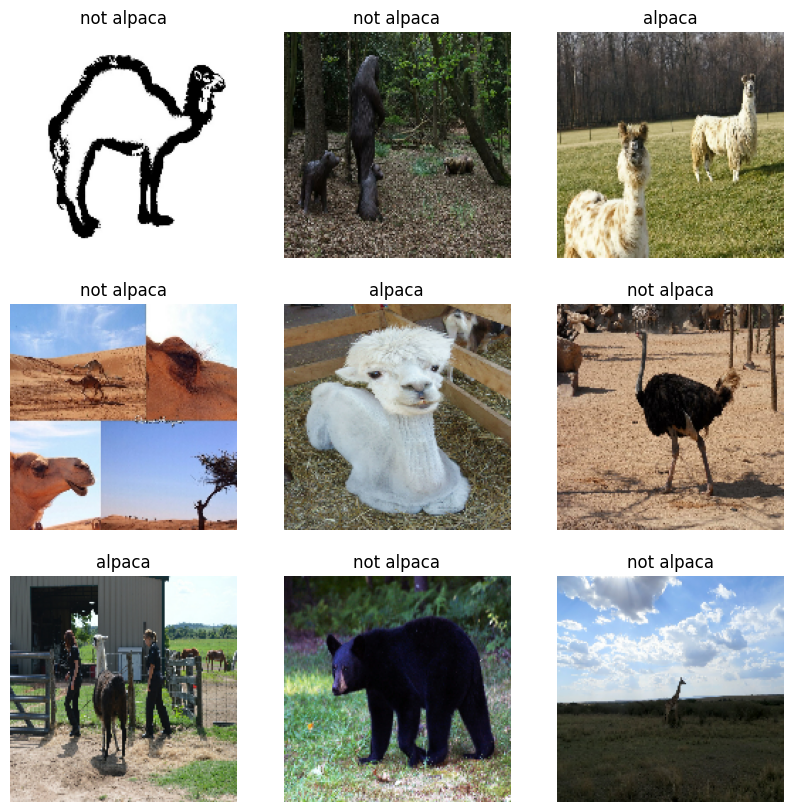

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 2 - Preprocess and Augment Training Data


#### Efficient Data Loading and Augmentation in TensorFlow

When working with large datasets, we can use `prefetch()` from the `tf.data` API to avoid memory bottlenecks. This method prepares data ahead of time, allowing us to stream it efficiently without needing the entire dataset to fit into memory.

We can either set the prefetch buffer size manually or let TensorFlow handle it dynamically using `tf.data.AUTOTUNE`. With `AUTOTUNE`, TensorFlow monitors processing times and optimizes performance by allocating CPU resources where they're most needed.

To help our model generalize better, we apply **data augmentation** techniques. By using Keras' `Sequential` API, we can easily add preprocessing layers that randomly flip and rotate images during training. These layers are integrated into the model, meaning they are saved and reusable — making our workflow both efficient and portable.


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 data augmentation layers: 
    random flipping and random rotation.
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2)
    ])
    return data_augmentation



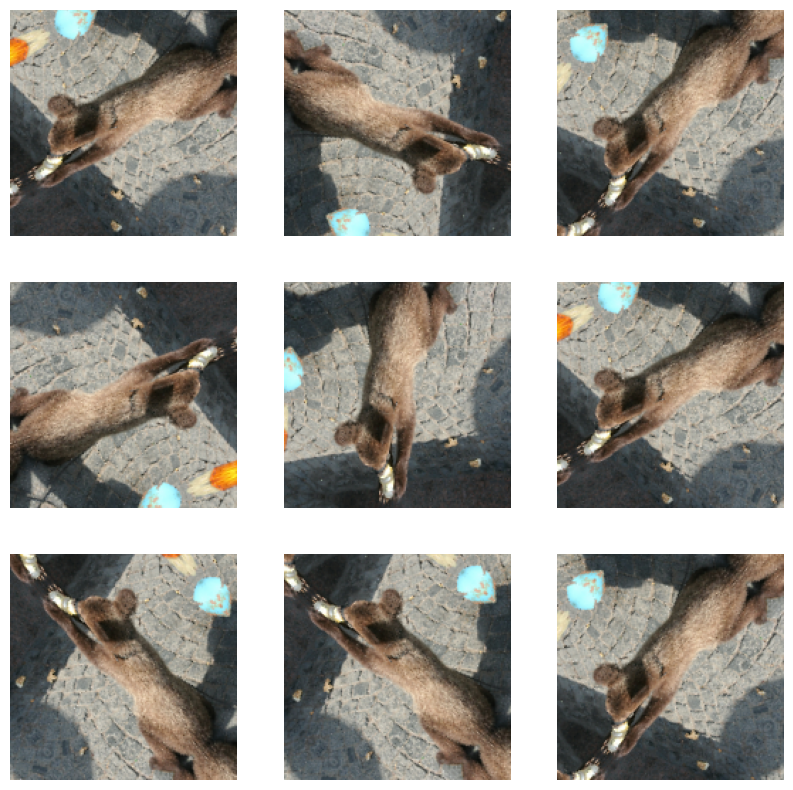

In [7]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

**IMPORTANT:**

* When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap
* Use prefetch() to prevent memory bottlenecks when reading from disk
* Give your model more to learn from with simple data augmentations like rotation and flipping.
* When using a pretrained model, it's best to reuse the weights it was trained on.

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## 3 - Using MobileNetV2 for Transfer Learning 
MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers
### 3.1 - Inside a MobileNetV2 Convolutional Building Block

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and  depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps: 

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: **Shape of the depthwise convolution X Number of filters.**

<img src="images/mobilenetv2.png" style="width:650px;height:450px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>MobileNetV2 Architecture</b> <br> This diagram was inspired by the original seen <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation.">here</a>.</center></caption>


In [9]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=True,
    weights='imagenet'
)
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

In [10]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


Notice some of the layers in the summary like `Conv2D` and `DepthwiseConv2D` and how they follow the progression of expansion to depthwise convolution to projection. In combination with BatchNormalization and ReLU, these make up the bottleneck layers mentioned earlier.

<font color='blue'>

**IMPORTANT**:

* MobileNetV2's unique features are: 
  * Depthwise separable convolutions that provide lightweight feature filtering and creation
  * Input and output bottlenecks that preserve important information on either end of the block
* Depthwise separable convolutions deal with both spatial and depth (number of channels) dimensions

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print("shape of feature_batch: ", feature_batch.shape)
#Shows the different label probabilities in one tensor 
print("label_batch:",label_batch)


shape of feature_batch:  (32, 1000)
label_batch: tf.Tensor([1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0], shape=(32,), dtype=int32)


The number 32 refers to the batch size and 1000 refers to the 1000 classes the model was pretrained on. The predictions returned by the base model below follow this format:

First the class number, then a human-readable label, and last the probability of the image belonging to that class.

In [12]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

# Function to decode predictions
def decode_predictions(preds, top=2):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(class_index[str(i)]) + (pred[i],) for i in top_indices]
        results.append(result)
    return results

with open("imagenet_base_model/imagenet_class_index.json", 'r') as f:
    class_index = json.load(f)
    
decoded_predictions = decode_predictions(pred.numpy(), top=2)
print(decoded_predictions)

[[('n02437312', 'Arabian_camel', 0.76831365), ('n02412080', 'ram', 0.18189746)], [('n01616318', 'vulture', 0.19584897), ('n02013706', 'limpkin', 0.1293609)], [('n02437616', 'llama', 0.66125476), ('n02090721', 'Irish_wolfhound', 0.23782912)], [('n03000684', 'chain_saw', 0.09556931), ('n03995372', 'power_drill', 0.0946101)], [('n02437616', 'llama', 0.90421724), ('n02099429', 'curly-coated_retriever', 0.03333137)], [('n02437312', 'Arabian_camel', 0.9568919), ('n02410509', 'bison', 0.006023464)], [('n02437312', 'Arabian_camel', 0.2566373), ('n02422106', 'hartebeest', 0.12122688)], [('n01518878', 'ostrich', 0.74165106), ('n02002724', 'black_stork', 0.072058275)], [('n04136333', 'sarong', 0.11354017), ('n04458633', 'totem_pole', 0.10245328)], [('n02134084', 'ice_bear', 0.9834193), ('n02120079', 'Arctic_fox', 0.0031842503)], [('n02493793', 'spider_monkey', 0.12630028), ('n01770393', 'scorpion', 0.06546413)], [('n02437616', 'llama', 0.94477606), ('n02423022', 'gazelle', 0.005433504)], [('n0242

Uh-oh. There's a whole lot of labels here, some of them hilariously wrong, but none of them say "alpaca."

This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when we use the full model, all we get is a bunch of incorrectly classified images.

Fortunately, we can delete the top layer, which contains all the classification labels, and create a new classification layer.

### 3.2 - Layer Freezing with the Functional API

<img src="images/snowalpaca.png" style="width:400px;height:250px;">

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [13]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    '''
    Define a tf.keras model for binary classification using the MobileNetV2 base.
    
    Arguments:
        image_shape -- Image width and height (tuple), e.g., (160, 160)
        data_augmentation -- Sequential model for augmenting images
    
    Returns:
        tf.keras.Model
    '''
    
    # Définir la forme d'entrée incluant les 3 canaux de couleur
    input_shape = image_shape + (3,)
    
    # Chemin vers les poids MobileNetV2 sans la couche de classification ("top")
    base_model_path = "imagenet_base_model/without_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5"
    
    # Charger MobileNetV2 sans le "top"
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights=base_model_path
    )
    
    # Geler les poids du modèle de base
    base_model.trainable = False

    # Définir l'entrée
    inputs = tf.keras.Input(shape=input_shape)
    
    # Appliquer les augmentations
    x = data_augmentation(inputs)
    
    # Prétraitement des images selon la méthode de MobileNetV2
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    
    # Extraire les caractéristiques avec le modèle de base
    x = base_model(x, training=False)
    
    # Pooling global moyen
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Dropout pour régularisation
    x = tf.keras.layers.Dropout(0.2)(x)
    
    # Couche de sortie : un neurone avec activation sigmoid pour classification binaire
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Créer le modèle
    model = tf.keras.Model(inputs, outputs)
    
    return model


In [14]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [15]:
alpaca_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
                    ['Sequential', (None, 160, 160, 3), 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['Functional', (None, 5, 5, 1280), 2257984],
                    ['GlobalAveragePooling2D', (None, 1280), 0],
                    ['Dropout', (None, 1280), 0, 0.2],
                    ['Dense', (None, 1), 1281, 'linear']] #linear is the default activation

for layer in alpaca_summary:
    print(layer)

['InputLayer', [(None, 160, 160, 3)], 0]
['Sequential', (None, 160, 160, 3), 0]
['TensorFlowOpLayer', [(None, 160, 160, 3)], 0]
['TensorFlowOpLayer', [(None, 160, 160, 3)], 0]
['Functional', (None, 5, 5, 1280), 2257984]
['GlobalAveragePooling2D', (None, 1280), 0]
['Dropout', (None, 1280), 0, 0.2]
['Dense', (None, 1), 1281, 'linear']


Compiling:

In [16]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training:

In [17]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5


c:\Users\samad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 404ms/step - accuracy: 0.3587 - loss: 1.0908 - val_accuracy: 0.7429 - val_loss: 0.4712
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.7543 - loss: 0.5841 - val_accuracy: 0.8857 - val_loss: 0.3424
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.8091 - loss: 0.6447 - val_accuracy: 0.8857 - val_loss: 0.3240
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.8025 - loss: 0.6142 - val_accuracy: 0.8571 - val_loss: 0.3248
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.8588 - loss: 0.4599 - val_accuracy: 0.8000 - val_loss: 0.3744


Ploting the training and validation accuracy:

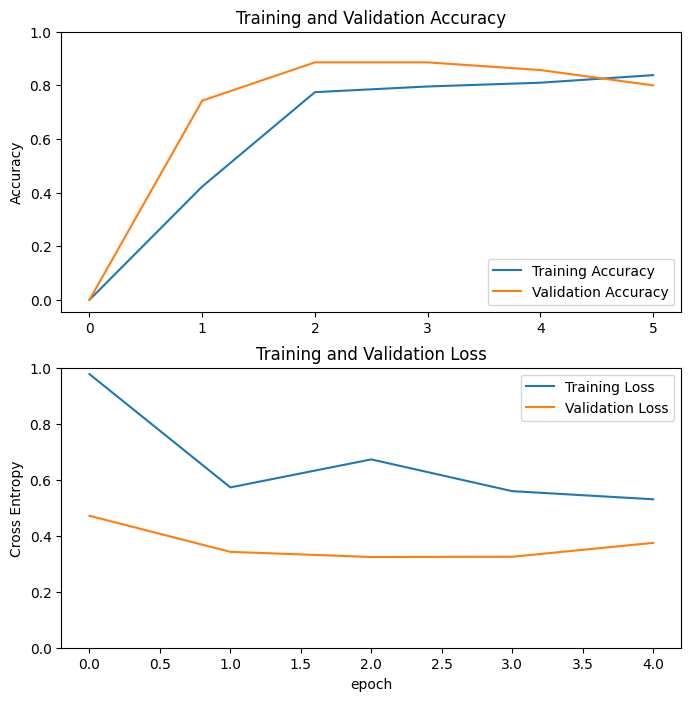

In [18]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
class_names

['alpaca', 'not alpaca']

### 3.3 - Fine-tuning the Model


## 🎯 Fine-Tuning in Transfer Learning

Once we’ve trained a model using transfer learning, we can often **improve our accuracy** by fine-tuning the **final layers** of the pre-trained base model.

---

### 🔍 Why Do We Fine-Tune?

- In the **early layers**, we learn **generic features** like edges or curves.
- In the **later layers**, we capture **task-specific features** such as fur patterns or object shapes.
- When adapting to a new dataset, we want to **adjust only the high-level features**, since the low-level ones are usually universal.

---

### 🛠️ How Do We Fine-Tune?

1. **Unfreeze the base model**  
   ```python
   base_model.trainable = True
   ```

2. **Choose the layer to start fine-tuning from**, and **freeze all layers before it**:  
   ```python
   for layer in base_model.layers[:fine_tune_from]:
       layer.trainable = False
   ```

3. **Recompile the model** with a **lower learning rate**:  
   This allows us to **make small, careful updates** to the weights.

4. **Continue training** for a few more epochs and evaluate if our accuracy improves.

---

### 💡 What Should We Keep in Mind?

- Fine-tuning lets us **adapt the model more precisely** to our specific task.
- We must use a **small learning rate** to avoid erasing the valuable knowledge the model already has.
- It's normal to **experiment with the number of layers to fine-tune**—different tasks may require different depths.
- After changing `trainable` status, we **must recompile** the model.

---

### 🧠 Real-Life Analogy

We can think of early layers as learning **basic outlines**, while the deeper layers learn to detect **more specific shapes**, like dog ears or cat eyes. For our new task, we **keep the outlines**, but we **retrain the details** to better suit our data.

```python
# Sample code to fine-tune the last layers
base_model.trainable = True
fine_tune_from = 100

for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(train_data,
                         validation_data=val_data,
                         epochs=5)
```


In [24]:
# Access the base model
base_model = model2.layers[2]
base_model.trainable = True

# Print number of layers in the base model
print("Number of layers in the base model:", len(base_model.layers))

# Fine-tune starting from this layer
fine_tune_at = 120

# Freeze all layers before `fine_tune_at`
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define the binary cross-entropy loss function (since this is a binary classification task)
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define the optimizer with a reduced learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)

# Use accuracy as the evaluation metric (wrapped in a list)
metrics = ['accuracy']

# Compile the model
model2.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=metrics
)


Number of layers in the base model: 154


In [25]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10


c:\Users\samad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - accuracy: 0.8090 - loss: 0.4559 - val_accuracy: 0.8286 - val_loss: 0.3107
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.8532 - loss: 0.3222 - val_accuracy: 0.8571 - val_loss: 0.2599
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.9093 - loss: 0.2638 - val_accuracy: 0.8857 - val_loss: 0.2359
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.9512 - loss: 0.1866 - val_accuracy: 0.8571 - val_loss: 0.2260
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.9964 - loss: 0.1565 - val_accuracy: 0.8571 - val_loss: 0.2295
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.9886 - loss: 0.1278 - val_accuracy: 0.8571 - val_loss: 0.2328


Ahhh, quite an improvement! A little fine-tuning can really go a long way.

In [26]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

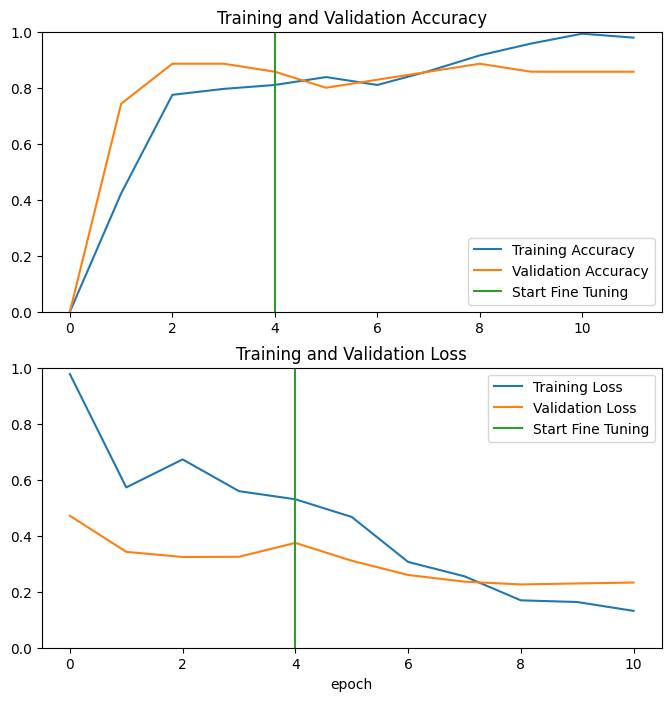

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<font color='blue'>

**IMPORTANT**:

* To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer
* When freezing layers, avoid keeping track of statistics (like in the batch normalization layer)
* Fine-tune the final layers of your model to capture high-level details near the end of the network and potentially improve accuracy 